In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import cv2
from PIL import Image
import os
import matplotlib.pyplot as plt

In [2]:
# 2 painters simple convnet

In [3]:
conv_base = keras.applications.vgg16.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(412, 550, 3) 
)

def get_features_and_labels(features, labels):
    print(features.shape)
    all_features = []
    for feature in features:
        feature = feature.reshape(-1, 412, 550, 3)
        preprocessed_image = keras.applications.vgg16.preprocess_input(feature)
        features = conv_base.predict(preprocessed_image)
        all_features.append(features)
    return np.concatenate(all_features), labels
        

def create_simpleconvnet():
    inputs = keras.Input(shape=(12, 17, 512))
    x = layers.Flatten()(inputs)
    x = layers.Dense(256)(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(2, activation='softmax')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    model.compile(loss="categorical_crossentropy",optimizer='adam', metrics=["accuracy"])

    model.summary()
    
    return model

In [4]:
model = create_simpleconvnet()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 12, 17, 512)]     0         
                                                                 
 flatten (Flatten)           (None, 104448)            0         
                                                                 
 dense (Dense)               (None, 256)               26738944  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 26739458 (102.00 MB)
Trainable params: 26739458

In [5]:
#mix arrays per n elements

def mix(elements1:[], elements2:[], n=5):
    objects_set = []
    labels_set = []
    i = 0
    while i < len(elements1) and i < len(elements2):
            objects_set.append(np.reshape(elements1[i], (412, 550, 3)))
            labels_set.append([1, 0])
    
            objects_set.append(np.reshape(elements2[i], (412, 550, 3)))
            labels_set.append([0, 1])
            
            i+=1
            
    return np.array(objects_set), np.array(labels_set)
    

(170, 412, 550, 3)
1/1 [==============================] - 0s 140ms/step
(200, 412, 550, 3)
1/1 [==============================] - 0s 140ms/step
200 200
Epoch 1/10
6/6 [==============================] - ETA: 0s - loss: 19.8440 - accuracy: 0.8353INFO:tensorflow:Assets written to: convnet_pretrained.ts\assets


INFO:tensorflow:Assets written to: convnet_pretrained.ts\assets


6/6 [==============================] - 2s 256ms/step - loss: 19.8440 - accuracy: 0.8353 - val_loss: 33.8717 - val_accuracy: 0.9200
Epoch 2/10
6/6 [==============================] - ETA: 0s - loss: 14.9405 - accuracy: 0.9529INFO:tensorflow:Assets written to: convnet_pretrained.ts\assets


INFO:tensorflow:Assets written to: convnet_pretrained.ts\assets


6/6 [==============================] - 1s 232ms/step - loss: 14.9405 - accuracy: 0.9529 - val_loss: 13.5049 - val_accuracy: 0.9600
Epoch 3/10
6/6 [==============================] - 1s 134ms/step - loss: 1.8354 - accuracy: 0.9824 - val_loss: 14.0092 - val_accuracy: 0.9550
Epoch 4/10
6/6 [==============================] - 1s 131ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 23.1729 - val_accuracy: 0.9450
Epoch 5/10
6/6 [==============================] - 1s 132ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 31.6139 - val_accuracy: 0.9400
Epoch 6/10
6/6 [==============================] - 1s 133ms/step - loss: 0.0045 - accuracy: 0.9941 - val_loss: 30.0881 - val_accuracy: 0.9400
Epoch 7/10
6/6 [==============================] - 1s 132ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 26.8131 - val_accuracy: 0.9450


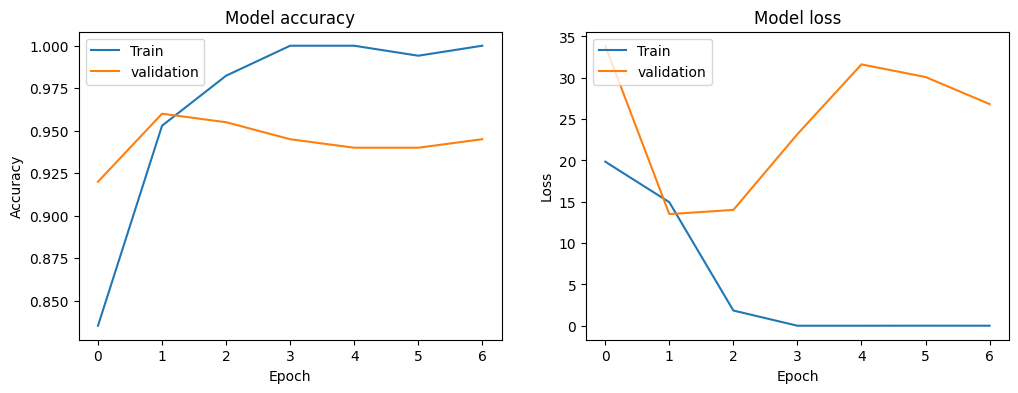

In [6]:
cwd = os.getcwd()
dir_train_rubens = "dataset/validation/rubens"
dir_train_picasso= "dataset/validation/picasso"
dir_validation_rubens = "dataset/test/rubens"
dir_validation_picasso= "dataset/test/picasso"
file_train_rubens = os.listdir(dir_train_rubens)
file_validation_rubens = os.listdir(dir_validation_rubens)
file_train_picasso = os.listdir(dir_train_picasso)
file_validation_picasso = os.listdir(dir_validation_picasso)

train_rubens =[Image.open(os.path.join(dir_train_rubens, file)) for file in file_train_rubens]
train_picasso =[Image.open(os.path.join(dir_train_picasso, file)) for file in file_train_picasso]
validation_rubens = [Image.open(os.path.join(dir_validation_rubens, file)) for file in file_validation_rubens]
validation_picasso = [Image.open(os.path.join(dir_validation_picasso, file)) for file in file_validation_picasso]

train_set, train_labels = mix(train_rubens, train_picasso)
validation_set, validation_labels = mix(validation_rubens, validation_picasso)

train_set = train_set.reshape(len(train_set), 412, 550, 3)
validation_set = validation_set.reshape(len(validation_set), 412, 550, 3)

train_set, train_labels = get_features_and_labels(train_set, train_labels)
validation_set, n = get_features_and_labels(validation_set, validation_labels)

print(len(validation_set), len(n))

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="convnet_pretrained.ts", save_best_only=True, monitor="val_loss"),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5)
]

history = model.fit(train_set, train_labels, validation_data=(validation_set, n), epochs=10, callbacks=callbacks)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')

plt.show()

In [7]:
from sklearn.preprocessing import MinMaxScaler

model = keras.models.load_model('convnet_pretrained.tf')

layer_output = []
layer_names = []
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        layer_output.append(layer.output)
        layer_names.append(layer.name)
        
activation_model = keras.Model(inputs=model.input, outputs=layer_output)

img_path = Image.open("dataset/test/picasso/1468.jpg")
img_path = np.reshape(img_path, (412, 550, 3))
img_path = np.expand_dims(img_path, axis=0)

img_path , _ = get_features_and_labels(img_path, None)

activations = activation_model.predict(img_path)

images_per_row = 4
for layer_name, layer_activations in zip(layer_names, activations):
    n_features = layer_activations.shape[-1]
    height = layer_activations.shape[2]
    width = layer_activations.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros(((width + 1) * n_cols - 1, images_per_row * (height + 1) - 1))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            chanal_index = col * images_per_row + row
            channel_img = layer_activations[0, :, :, chanal_index].copy()
            
            if channel_img.sum() != 0:
                channel_img -= channel_img.mean()
                channel_img /= channel_img.std()
                channel_img *= 64
                channel_img += 128

            channel_img = np.clip(channel_img, 0, 255).astype(np.uint8)

            display_grid[
                col * (width + 1) : (col + 1) * width + col, 
                row * (height + 1) : (row + 1) * height + row
            ] = channel_img

    scale_width = 1.0 / width
    scale_height = 1.0 / height
    plt.figure(figsize=(scale_height * display_grid.shape[1],scale_width * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    # plt.imshow(display_grid, aspect='auto', cmap='viridis')


OSError: No file or directory found at convnet_pretrained.tf

In [ ]:
cwd = os.getcwd()
dir_test_rubens = "dataset/test/rubens"
dir_test_picasso= "dataset/test/picasso"
file_test_rubens = os.listdir(dir_test_rubens)
file_test_picasso = os.listdir(dir_test_picasso)

test_rubens = [Image.open(os.path.join(dir_test_rubens, file)) for file in file_validation_rubens]
test_picasso = [Image.open(os.path.join(dir_test_picasso, file)) for file in file_test_picasso]

test_set, test_labels = mix(test_rubens, test_picasso)

test_set = test_set.reshape(len(test_set), 412, 550, 3)

test_model = keras.models.load_model('convnet_from_scratch.ts')
test_loss, test_acc = test_model.evaluate(test_set, test_labels)
print('Test loss:', test_loss)